In [1]:

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
x = []
id = []
import os
import numpy as np
for dirname, _, filenames in os.walk('/kaggle/input/datathonfinalround/'):
#     print(dirname)
    for filename in filenames:
#         print(dirname+filename)
        x.append(dirname+'/'+filename)
        id.append(filename[:-4])
# Any results you write to the current directory are saved as output.
del x[0:2]
del id[0:2]

import pandas as pd
y = pd.read_csv('/kaggle/input/datathonfinalround/labels.csv')
y.head()

trainlist = pd.DataFrame(id,columns=['id'])
trainlist['path'] = x
trainlist = trainlist.sort_values('id')
trainlist.set_index('id',inplace=True)
tr = trainlist.drop(trainlist.tail(20000).index)

trainlabel = y['Expected'][0:60001]
trainlabel.to_csv('/kaggle/working/trainlabel.csv',header = False)
tr.to_csv('/kaggle/working/trainpath.csv')

x_path = '/kaggle/working/trainpath.csv'
y_path = '/kaggle/working/trainlabel.csv'
x_file = pd.read_csv(x_path)
y_file = pd.read_csv(y_path)
x = x_file['path']
x = x[:60000]
y = y_file['1']

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:

print(x[59999])
print(y[59998])
print(len(x))
print(len(y))

/kaggle/input/datathonfinalround/train-images-5/Train-Images-5/060000.jpg
8
60000
60000


In [3]:
#df_label = pd.read_csv('/kaggle/input/datathonfinalround/labels.csv')
#m = df_label
#m = df_label['Expected']
#y = m[:10000]

In [4]:
df_submit = pd.read_csv('/kaggle/input/datathonfinalround/sampleSubmission.csv')
df_submit.shape

(4, 2)

****
input path: ../input/datathonfinalround/labels.csv

In [5]:
ls

__notebook_source__.ipynb  trainlabel.csv  trainpath.csv


In [6]:
import cv2
im = cv2.imread('/kaggle/input/datathonfinalround/train-images-1/Train-Images-1/000001.jpg')
im.shape
im2 = cv2.resize(im,(624,468))
im2.shape

(468, 624, 3)

**create model and try to train**

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [8]:
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy, categorical_crossentropy
#from keras.applications.resnet50 import preprocess_input
from keras.applications.densenet import DenseNet121,DenseNet169
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import imgaug as ia

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
HEIGHT = 300
WIDTH = 300
NUM_CLASSES = 13

array([ 0.26721773,  0.59088268, 53.66726297,  1.26761456,  1.15240565,
        8.22706705,  1.302677  ,  0.62118232,  2.11812052,  0.99813681,
        1.95899177,  0.89880908,  3.40116773])

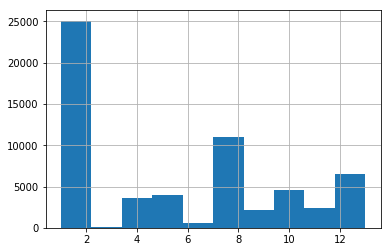

In [9]:
x, y = shuffle(x, y, random_state=8)
y.hist()
y = y-1
classWeights = class_weight.compute_class_weight('balanced',np.unique(y),y)
classWeights = classWeights
classWeights

In [10]:
y = to_categorical(y, num_classes=NUM_CLASSES)
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=8)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(51000,)
(51000, 13)
(9000,)
(9000, 13)


In [11]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-10, 10), # rotate by -45 to +45 degrees
                shear=(-5, 5), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    iaa.Invert(0.01, per_channel=True), # invert color channels
                    iaa.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.9, 1.1), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=iaa.Multiply((0.9, 1.1), per_channel=True),
                            second=iaa.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True)

In [12]:
x[1]

'/kaggle/input/datathonfinalround/train-images-1/Train-Images-1/000002.jpg'

In [13]:
class My_Generator(Sequence):

    def __init__(self, image_filenames, labels,
                 batch_size, is_train=True,
                 mix=False, augment=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_augment = augment
        if(self.is_train):
            self.on_epoch_end()
        self.is_mix = mix

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        if(self.is_train):
            return self.train_generate(batch_x, batch_y)
        return self.valid_generate(batch_x, batch_y)

    def on_epoch_end(self):
        if(self.is_train):
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
        else:
            pass
    
    def mix_up(self, x, y):
        lam = np.random.beta(0.2, 0.4)
        ori_index = np.arange(int(len(x)))
        index_array = np.arange(int(len(x)))
        np.random.shuffle(index_array)        
        
        mixed_x = lam * x[ori_index] + (1 - lam) * x[index_array]
        mixed_y = lam * y[ori_index] + (1 - lam) * y[index_array]
        
        return mixed_x, mixed_y

    def train_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            #img = cv2.imread('../input/aptos2019-blindness-detection/train_images/'+sample+'.png')
            img = cv2.imread(sample)
            img = cv2.resize(img, (WIDTH, HEIGHT))
            if(self.is_augment):
                img = seq.augment_image(img)
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        if(self.is_mix):
            batch_images, batch_y = self.mix_up(batch_images, batch_y)
        return batch_images, batch_y

    def valid_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            #img = cv2.imread('../input/aptos2019-blindness-detection/train_images/'+sample+'.png')
            img = cv2.imread(sample)
            img = cv2.resize(img, (WIDTH, HEIGHT))
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y


In [14]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = DenseNet121(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    base_model.load_weights("/kaggle/input/densenetmodel/DenseNet-BC-121-32-no-top.h5//DenseNet-BC-121-32-no-top.h5")
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output) 
    return model

In [15]:
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

epochs = 10; batch_size = 32
checkpoint = ModelCheckpoint('/kaggle/working/densenet_.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=9)

csv_logger = CSVLogger(filename='/kaggle/working/training_log.csv',
                       separator=',',
                       append=True)

#train_generator = My_Generator(train_x, train_y, 128, is_train=True)
#train_mixup = My_Generator(train_x, train_y, batch_size, is_train=True, mix=False, augment=True)
#valid_generator = My_Generator(valid_x, valid_y, batch_size, is_train=False)

model = create_model(
    input_shape=(HEIGHT,WIDTH,3), 
    n_out=NUM_CLASSES)

In [16]:
#model.load_weights('/kaggle/working/densenet_bestqwk.h5')

In [17]:
# cd /kaggle/input/densenetmodel/DenseNet-BC-121-32-no-top.h5/

In [18]:
ls

__notebook_source__.ipynb  trainlabel.csv  trainpath.csv


In [20]:
from keras.callbacks import Callback
class QWKEvaluation(Callback):
    def __init__(self, validation_data=(), batch_size=64, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.batch_size = batch_size
        self.valid_generator, self.y_val = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_generator(generator=self.valid_generator,
                                                  steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
                                                  workers=1, use_multiprocessing=False,
                                                  verbose=1)
            def flatten(y):
                return np.argmax(y, axis=1).reshape(-1)
            
            score = cohen_kappa_score(flatten(self.y_val),
                                      flatten(y_pred),
                                      labels=[1,2,3,4,5,6,7,8,9,10,11,12,13],
                                      weights='quadratic')
            print("\n epoch: %d - QWK_score: %.6f \n" % (epoch+1, score))
            self.history.append(score)
            predict = np.sum(flatten(self.y_val)==flatten(y_pred))/len(flatten(y_pred))
            print(predict)
            if score >= max(self.history):
                print('saving checkpoint: ', score)
                self.model.save('/kaggle/working/densenet_bestqwk.h5')

qwk = QWKEvaluation(validation_data=(valid_generator, valid_y),
                    batch_size=batch_size, interval=1)

NameError: name 'valid_generator' is not defined

In [ ]:
# warm up model
for layer in model.layers:
    layer.trainable = False

for i in range(-3,0):
    model.layers[i].trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-3))

model.fit_generator(
    train_generator,
    class_weight = classWeights,
    steps_per_epoch=np.ceil(float(len(train_y)) / float(128)),
    epochs=2,
    workers=WORKERS, use_multiprocessing=True,
    verbose=1,
    callbacks=[qwk])

In [ ]:
epochs = 1;
# train all layers
for layer in model.layers:
    layer.trainable = True
callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early, qwk]
model.compile(loss='categorical_crossentropy',
            # loss=kappa_loss,
            optimizer=Adam(lr=1e-4))
model.fit_generator(
    train_mixup,
    class_weight = classWeights,
    steps_per_epoch=np.ceil(float(len(train_x)) / float(batch_size)),
    validation_data=valid_generator,
    validation_steps=np.ceil(float(len(valid_x)) / float(batch_size)),
    epochs=epochs,
    verbose=1,
    workers=2, use_multiprocessing=True,
    callbacks=callbacks_list)

In [21]:
submit = pd.read_csv('/kaggle/input/datathonfinalround/sampleSubmission.csv')
model.load_weights('/kaggle/input/bestmodel/densenet_bestqwk.h5')
predicted = []
id_test = []

In [22]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[-2:]]
activation_Model = models.Model(inputs=model.input, outputs=layer_outputs)

In [23]:
ls

__notebook_source__.ipynb  trainlabel.csv  trainpath.csv


In [24]:

img_path =[]
for dirname, _, filenames in os.walk('/kaggle/input/datathonfinalround/test-images/Test-Images'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        img_path.append(os.path.join(dirname, filename))
len(img_path)
img_path[0]

KeyboardInterrupt: 

In [25]:
samplesFile= pd.read_csv('/kaggle/input/randomsamples/a_ext.csv')
img_path = samplesFile['path']


In [26]:

data = []
from sklearn.decomposition import PCA 
pca=PCA(n_components=2)
for i in range(len(img_path)):
    path = '/'+img_path[i]
    image = cv2.imread(path)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    X = np.array((image[np.newaxis])/255)
    activations = activation_Model.predict(X)
    data.append(activations[0][0])
    print(i)
newData=pca.fit_transform(data)
print('down')
labelMaps = []
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [29]:
labelMapFiles = pd.read_csv('/kaggle/input/labelmaps/labelmaps.csv')
img_path = labelMapFiles['path']
labelMaps = []
for i in range(len(img_path)):
    path_cur = img_path[i]+'.jpg'
    print(path_cur)
    image = cv2.imread(path_cur)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    X = np.array((image[np.newaxis])/255)
    activations = activation_Model.predict(X)
    labelMap = pca.transform(activations[0])
    labelMaps.append(labelMap)

/kaggle/input/datathonfinalround/train-images-1/Train-Images-1/000210.jpg
/kaggle/input/datathonfinalround/train-images-1/Train-Images-1/000209.jpg
/kaggle/input/datathonfinalround/train-images-1/Train-Images-1/000212.jpg
/kaggle/input/datathonfinalround/train-images-1/Train-Images-1/000187.jpg
/kaggle/input/datathonfinalround/train-images-1/Train-Images-1/000185.jpg
/kaggle/input/datathonfinalround/train-images-1/Train-Images-1/000191.jpg
/kaggle/input/datathonfinalround/train-images-1/Train-Images-1/006658.jpg
/kaggle/input/datathonfinalround/train-images-1/Train-Images-1/000758.jpg
/kaggle/input/datathonfinalround/train-images-1/Train-Images-1/000761.jpg
/kaggle/input/datathonfinalround/train-images-1/Train-Images-1/000643.jpg
/kaggle/input/datathonfinalround/train-images-1/Train-Images-1/000644.jpg
/kaggle/input/datathonfinalround/train-images-1/Train-Images-1/009839.jpg
/kaggle/input/datathonfinalround/train-images-1/Train-Images-1/009999.jpg
/kaggle/input/datathonfinalround/train

In [30]:
labelMapFiles

,path,label,ori
0,/kaggle/input/datathonfinalround/train-images-...,1,0
1,/kaggle/input/datathonfinalround/train-images-...,1,1
2,/kaggle/input/datathonfinalround/train-images-...,1,2
3,/kaggle/input/datathonfinalround/train-images-...,2,0
4,/kaggle/input/datathonfinalround/train-images-...,2,1
5,/kaggle/input/datathonfinalround/train-images-...,2,2
6,/kaggle/input/datathonfinalround/train-images-...,3,0
7,/kaggle/input/datathonfinalround/train-images-...,3,1
8,/kaggle/input/datathonfinalround/train-images-...,3,2
9,/kaggle/input/datathonfinalround/train-images-...,4,0


In [ ]:
for i in range(100001,120001):
    path = os.path.join('/kaggle/input/datathonfinalround/test-images/Test-Images/', str(i)+'.jpg')
    print(path)
    image = cv2.imread(path)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    X = np.array((image[np.newaxis])/255)
    score_predict=((model.predict(X).ravel()*model.predict(X[:, ::-1, :, :]).ravel()*model.predict(X[:, ::-1, ::-1, :]).ravel()*model.predict(X[:, :, ::-1, :]).ravel())**0.25).tolist()
    label_predict = np.argmax(score_predict)
    activations = activation_Model.predict(X)
    mapping = pca.transform(activations[0])
    mapping = np.reshape(mapping,(-1,1))
    max_dis = 100
    for j in range(label_predict*3,label_predict*3+3):
        label = 0
        if np.sum(np.square(mapping-labelMaps[j]))<max_dis:
            max_dis = np.sum(np.square(mapping-labelMaps[j]))
            label = j%3
    print(label)
    print(label_predict)
    predicted.append(str(label))
    #predicted.append(str(1))
    id_test.append(str(i))

/kaggle/input/datathonfinalround/test-images/Test-Images/100001.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100002.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100003.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100004.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100005.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100006.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100007.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100008.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100009.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100010.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100011.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100012.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100013.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100014.

2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100115.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100116.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100117.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100118.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100119.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100120.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100121.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100122.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100123.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100124.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100125.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100126.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100127.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100

2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100229.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100230.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100231.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100232.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100233.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100234.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100235.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100236.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100237.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100238.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100239.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100240.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100241.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100343.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100344.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100345.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100346.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100347.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100348.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100349.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100350.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100351.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100352.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100353.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100354.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100355.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100457.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100458.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100459.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100460.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100461.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100462.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100463.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100464.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100465.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100466.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100467.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100468.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100469.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100572.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100573.jpg
0
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100574.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100575.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100576.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100577.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100578.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100579.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100580.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100581.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100582.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100583.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100584.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100

2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/100686.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100687.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100688.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100689.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100690.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100691.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100692.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100693.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100694.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100695.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100696.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100697.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100698.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100800.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100801.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100802.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100803.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100804.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100805.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100806.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100807.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100808.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100809.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100810.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100811.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100812.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100914.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100915.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100916.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100917.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100918.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100919.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100920.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100921.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100922.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100923.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100924.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100925.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100926.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/100

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101029.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101030.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101031.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101032.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101033.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101034.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101035.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101036.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101037.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101038.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101039.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101040.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101041.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101143.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101144.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101145.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101146.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101147.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101148.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101149.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101150.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101151.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101152.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101153.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/101154.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101155.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101257.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101258.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101259.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101260.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101261.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101262.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101263.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101264.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101265.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101266.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101267.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101268.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101269.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101372.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101373.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101374.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101375.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101376.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101377.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101378.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101379.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101380.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101381.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101382.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101383.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101384.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/101

2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101486.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/101487.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101488.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101489.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101490.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101491.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101492.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101493.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101494.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101495.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101496.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101497.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101498.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101600.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101601.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101602.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101603.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101604.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101605.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101606.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/101607.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101608.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101609.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101610.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101611.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101612.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/101

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101714.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101715.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101716.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101717.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101718.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101719.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101720.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101721.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101722.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101723.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101724.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101725.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101726.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101828.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101829.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101830.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/101831.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/101832.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101833.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101834.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/101835.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/101836.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101837.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/101838.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/101839.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/101840.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101942.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101943.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101944.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101945.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101946.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101947.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101948.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101949.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101950.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101951.jpg
0
3
/kaggle/input/datathonfinalround/test-images/Test-Images/101952.jpg
0
3
/kaggle/input/datathonfinalround/test-images/Test-Images/101953.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101954.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/101

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102056.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102057.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102058.jpg
0
6
/kaggle/input/datathonfinalround/test-images/Test-Images/102059.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102060.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/102061.jpg
0
6
/kaggle/input/datathonfinalround/test-images/Test-Images/102062.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102063.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102064.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102065.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102066.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102067.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102068.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102

2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/102171.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/102172.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102173.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102174.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102175.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102176.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102177.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102178.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102179.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102180.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102181.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102182.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102183.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102285.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102286.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102287.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102288.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102289.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102290.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102291.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102292.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102293.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102294.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102295.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102296.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102297.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102400.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102401.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102402.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102403.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102404.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102405.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102406.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102407.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102408.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102409.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102410.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102411.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102412.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102515.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102516.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102517.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102518.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102519.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102520.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102521.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102522.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102523.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/102524.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/102525.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102526.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102527.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102629.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102630.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102631.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102632.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102633.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102634.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102635.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102636.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102637.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102638.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102639.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102640.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102641.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102743.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/102744.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/102745.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102746.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/102747.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/102748.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102749.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102750.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/102751.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/102752.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102753.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/102754.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/102755.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/102

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102857.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102858.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102859.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102860.jpg
0
6
/kaggle/input/datathonfinalround/test-images/Test-Images/102861.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102862.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/102863.jpg
0
6
/kaggle/input/datathonfinalround/test-images/Test-Images/102864.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102865.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/102866.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102867.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102868.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102869.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102971.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102972.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102973.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102974.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102975.jpg
0
6
/kaggle/input/datathonfinalround/test-images/Test-Images/102976.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102977.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102978.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102979.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102980.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102981.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102982.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102983.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/102

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103085.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103086.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103087.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103088.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103089.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/103090.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103091.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103092.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103093.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103094.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103095.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103096.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103097.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103200.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103201.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/103202.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103203.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103204.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103205.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103206.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103207.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103208.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103209.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103210.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103211.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103212.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103315.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103316.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103317.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103318.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103319.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103320.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103321.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103322.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103323.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103324.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103325.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103326.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103327.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103429.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103430.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103431.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103432.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103433.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103434.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103435.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103436.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103437.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103438.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103439.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103440.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103441.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103

2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/103543.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103544.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103545.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103546.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103547.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103548.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103549.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103550.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103551.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103552.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103553.jpg
0
9
/kaggle/input/datathonfinalround/test-images/Test-Images/103554.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103555.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103657.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103658.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103659.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103660.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103661.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103662.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103663.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103664.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103665.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103666.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103667.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103668.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103669.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103772.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103773.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103774.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103775.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103776.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/103777.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103778.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103779.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103780.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103781.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103782.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103783.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103784.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103886.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103887.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103888.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103889.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103890.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103891.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103892.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103893.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103894.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103895.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/103896.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/103897.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/103898.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/103

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104000.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104001.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104002.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104003.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104004.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104005.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104006.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104007.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104008.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104009.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104010.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104011.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104012.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104115.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104116.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104117.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104118.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104119.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104120.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104121.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104122.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104123.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104124.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104125.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104126.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104127.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104229.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104230.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104231.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104232.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104233.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104234.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104235.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104236.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104237.jpg
0
6
/kaggle/input/datathonfinalround/test-images/Test-Images/104238.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104239.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/104240.jpg
0
6
/kaggle/input/datathonfinalround/test-images/Test-Images/104241.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104343.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104344.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104345.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104346.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104347.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104348.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104349.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104350.jpg
0
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104351.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104352.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104353.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104354.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104355.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104

0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104458.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104459.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104460.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104461.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104462.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104463.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104464.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104465.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104466.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104467.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104468.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104469.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104470.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104573.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104574.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104575.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104576.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104577.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104578.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104579.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104580.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104581.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104582.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104583.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104584.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104585.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104687.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104688.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104689.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104690.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104691.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104692.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104693.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104694.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104695.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104696.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104697.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104698.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104699.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104

2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104802.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104803.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104804.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104805.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104806.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104807.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104808.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104809.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104810.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104811.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104812.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104813.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104814.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104916.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104917.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104918.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104919.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104920.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104921.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104922.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104923.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104924.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104925.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104926.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104927.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104928.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/104

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105030.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105031.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105032.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105033.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105034.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105035.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105036.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105037.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105038.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105039.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105040.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105041.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105042.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105144.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105145.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105146.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105147.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105148.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105149.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105150.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105151.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105152.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105153.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105154.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105155.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105156.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105

0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105258.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105259.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105260.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105261.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105262.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105263.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105264.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105265.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105266.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105267.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105268.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105269.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105270.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105373.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105374.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105375.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105376.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105377.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105378.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105379.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105380.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105381.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105382.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105383.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105384.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105385.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105

2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105487.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105488.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105489.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105490.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105491.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105492.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105493.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105494.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105495.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105496.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105497.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105498.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105499.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105

2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105602.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105603.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105604.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105605.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105606.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105607.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105608.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105609.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105610.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105611.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105612.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105613.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105614.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105716.jpg
0
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105717.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105718.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105719.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105720.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105721.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105722.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105723.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105724.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105725.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105726.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105727.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105728.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105830.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105831.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105832.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105833.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105834.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105835.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105836.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105837.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105838.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105839.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105840.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105841.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105842.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105945.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105946.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105947.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105948.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/105949.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105950.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105951.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105952.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105953.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105954.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105955.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105956.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105957.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/105

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106060.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106061.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106062.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106063.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106064.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106065.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106066.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106067.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106068.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106069.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106070.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106071.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106072.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106

0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106174.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106175.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106176.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106177.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106178.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106179.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106180.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106181.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106182.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106183.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106184.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106185.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106186.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106

2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106288.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106289.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106290.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106291.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106292.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106293.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106294.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106295.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106296.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106297.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106298.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106299.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106300.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106403.jpg
0
6
/kaggle/input/datathonfinalround/test-images/Test-Images/106404.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106405.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/106406.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106407.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106408.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/106409.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106410.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106411.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106412.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106413.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106414.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106415.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/106

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106517.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106518.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106519.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106520.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106521.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106522.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106523.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106524.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106525.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106526.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106527.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106528.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106529.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106631.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106632.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106633.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106634.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106635.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106636.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106637.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106638.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106639.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106640.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106641.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106642.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106643.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106746.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106747.jpg
0
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106748.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106749.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106750.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106751.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106752.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106753.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106754.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106755.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106756.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106757.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106758.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106861.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106862.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106863.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106864.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106865.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106866.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106867.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106868.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106869.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106870.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106871.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106872.jpg
0
6
/kaggle/input/datathonfinalround/test-images/Test-Images/106873.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106975.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106976.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106977.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106978.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106979.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106980.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106981.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106982.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106983.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106984.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106985.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106986.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106987.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/106

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107089.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107090.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107091.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107092.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107093.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107094.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107095.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107096.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107097.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107098.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107099.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107100.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107101.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107203.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107204.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107205.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107206.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107207.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107208.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107209.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107210.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107211.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107212.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107213.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107214.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107215.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107317.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107318.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107319.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107320.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107321.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107322.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107323.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107324.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107325.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107326.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107327.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107328.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107329.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107432.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107433.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107434.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107435.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107436.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107437.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107438.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107439.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107440.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107441.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107442.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107443.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107444.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107546.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107547.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107548.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107549.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107550.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107551.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107552.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107553.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107554.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107555.jpg
0
6
/kaggle/input/datathonfinalround/test-images/Test-Images/107556.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107557.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107558.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107660.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107661.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107662.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107663.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107664.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107665.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107666.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107667.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107668.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107669.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107670.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107671.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107672.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107774.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107775.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107776.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107777.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107778.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107779.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107780.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107781.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107782.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107783.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107784.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107785.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107786.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107

2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107888.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107889.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107890.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107891.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107892.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107893.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107894.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107895.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/107896.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/107897.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/107898.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/107899.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/107900.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/107

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108002.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108003.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108004.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108005.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108006.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108007.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108008.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108009.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108010.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108011.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108012.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108013.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108014.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108116.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108117.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108118.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108119.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108120.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108121.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108122.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108123.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108124.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108125.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108126.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108127.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108128.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108231.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108232.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108233.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108234.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108235.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108236.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108237.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108238.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108239.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108240.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108241.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108242.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108243.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108

2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108345.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108346.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108347.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108348.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108349.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108350.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108351.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108352.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108353.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108354.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108355.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108356.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108357.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108460.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108461.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108462.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108463.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108464.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108465.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108466.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108467.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108468.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108469.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108470.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108471.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108472.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108575.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108576.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108577.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108578.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108579.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108580.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108581.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108582.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108583.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108584.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108585.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108586.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108587.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108

2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108689.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108690.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108691.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108692.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108693.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108694.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108695.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108696.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108697.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108698.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108699.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108700.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108701.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108

2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108804.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108805.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108806.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108807.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108808.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108809.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108810.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108811.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108812.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108813.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108814.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108815.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108816.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108918.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108919.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108920.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108921.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108922.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108923.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108924.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108925.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108926.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108927.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/108928.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108929.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108930.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108

2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109033.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109034.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109035.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109036.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109037.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109038.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109039.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109040.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109041.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109042.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109043.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109044.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109045.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109148.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109149.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109150.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109151.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109152.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109153.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109154.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109155.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109156.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109157.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109158.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109159.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109160.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109262.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109263.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109264.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109265.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109266.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109267.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109268.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109269.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109270.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109271.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109272.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109273.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109274.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109376.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109377.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109378.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109379.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109380.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109381.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109382.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109383.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109384.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109385.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109386.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109387.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109388.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109490.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109491.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109492.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109493.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109494.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/109495.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109496.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/109497.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/109498.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/109499.jpg
0
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109500.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109501.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109502.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109

2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109605.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109606.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109607.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109608.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109609.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109610.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109611.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109612.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109613.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109614.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109615.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109616.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109617.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109720.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109721.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109722.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109723.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109724.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109725.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109726.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109727.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109728.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109729.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109730.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109731.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109732.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109834.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109835.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109836.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109837.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109838.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109839.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109840.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109841.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109842.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109843.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109844.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109845.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109846.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109948.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109949.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109950.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109951.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109952.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109953.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109954.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109955.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109956.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109957.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109958.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109959.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109960.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/109

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110062.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110063.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110064.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110065.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110066.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110067.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110068.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110069.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/110070.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110071.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110072.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110073.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110074.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110177.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110178.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110179.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110180.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110181.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110182.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110183.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110184.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110185.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110186.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110187.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/110188.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110189.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110291.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110292.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110293.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110294.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110295.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110296.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110297.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110298.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110299.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110300.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110301.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110302.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110303.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110405.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110406.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110407.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110408.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110409.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110410.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110411.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110412.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110413.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110414.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110415.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110416.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110417.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110

2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/110519.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110520.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110521.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110522.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110523.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110524.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/110525.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110526.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110527.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110528.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110529.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110530.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110531.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110634.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110635.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110636.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/110637.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/110638.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110639.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110640.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110641.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110642.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110643.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110644.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110645.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110646.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110748.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110749.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110750.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110751.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110752.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110753.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110754.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110755.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110756.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/110757.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/110758.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/110759.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/110760.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/110

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110863.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110864.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/110865.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110866.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110867.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110868.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110869.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110870.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110871.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110872.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110873.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110874.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110875.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110978.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110979.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110980.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110981.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110982.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110983.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110984.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110985.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110986.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/110987.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110988.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110989.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/110990.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/110

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111092.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111093.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111094.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111095.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111096.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111097.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111098.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111099.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111100.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111101.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/111102.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/111103.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111104.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111206.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111207.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111208.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111209.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111210.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111211.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111212.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111213.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111214.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111215.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111216.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111217.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111218.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111

2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/111320.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111321.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/111322.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111323.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111324.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111325.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111326.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111327.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111328.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111329.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111330.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111331.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111332.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111435.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111436.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111437.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/111438.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111439.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/111440.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111441.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/111442.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/111443.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/111444.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111445.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111446.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111447.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111549.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111550.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111551.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111552.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111553.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111554.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111555.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111556.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111557.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111558.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111559.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111560.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111561.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111663.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111664.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111665.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/111666.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111667.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111668.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/111669.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111670.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111671.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111672.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111673.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111674.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111675.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111778.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111779.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111780.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111781.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111782.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111783.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111784.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111785.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/111786.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/111787.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/111788.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111789.jpg
2
6
/kaggle/input/datathonfinalround/test-images/Test-Images/111790.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111892.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111893.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111894.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111895.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111896.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111897.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111898.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111899.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111900.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111901.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111902.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111903.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/111904.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/111

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112007.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112008.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112009.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112010.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112011.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112012.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112013.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112014.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112015.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112016.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112017.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112018.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112019.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112

0
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112121.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112122.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112123.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112124.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112125.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112126.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112127.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112128.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112129.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112130.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112131.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112132.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112133.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112235.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112236.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112237.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112238.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112239.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112240.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112241.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112242.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112243.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112244.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112245.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112246.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112247.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112349.jpg
0
11
/kaggle/input/datathonfinalround/test-images/Test-Images/112350.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112351.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112352.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112353.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112354.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112355.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112356.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112357.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112358.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112359.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112360.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112361.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/11

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112463.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112464.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112465.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112466.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112467.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112468.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112469.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112470.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112471.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112472.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112473.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112474.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112475.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112577.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112578.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112579.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112580.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112581.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112582.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112583.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112584.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112585.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112586.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112587.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112588.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112589.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112691.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112692.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112693.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112694.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112695.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112696.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112697.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112698.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112699.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112700.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112701.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112702.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112703.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112

2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112805.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112806.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112807.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112808.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112809.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112810.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112811.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112812.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112813.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112814.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112815.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112816.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112817.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112919.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112920.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112921.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112922.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112923.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112924.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112925.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112926.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112927.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112928.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112929.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112930.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112931.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/112

2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113033.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113034.jpg
2
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113035.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113036.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113037.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113038.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113039.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113040.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113041.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113042.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113043.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113044.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113045.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113147.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113148.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113149.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113150.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113151.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113152.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113153.jpg
0
11
/kaggle/input/datathonfinalround/test-images/Test-Images/113154.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113155.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113156.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113157.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113158.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113159.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/11

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113261.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113262.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113263.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113264.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113265.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113266.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113267.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113268.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113269.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113270.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113271.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113272.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113273.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113376.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113377.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113378.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113379.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113380.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113381.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113382.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113383.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113384.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113385.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113386.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113387.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113388.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113490.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113491.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113492.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113493.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113494.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113495.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113496.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113497.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113498.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113499.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113500.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113501.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113502.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113604.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113605.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113606.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113607.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113608.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113609.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113610.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113611.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113612.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113613.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113614.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113615.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113616.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113

2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113718.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113719.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113720.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113721.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113722.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113723.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113724.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113725.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113726.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113727.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113728.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113729.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113730.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113

0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113832.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113833.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113834.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113835.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113836.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113837.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113838.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113839.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113840.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113841.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113842.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113843.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113844.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113946.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/113947.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113948.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113949.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113950.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113951.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113952.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113953.jpg
0
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113954.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113955.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113956.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113957.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113958.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114061.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114062.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114063.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114064.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114065.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114066.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114067.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114068.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114069.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114070.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114071.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114072.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114073.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114

0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114175.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114176.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114177.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114178.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114179.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114180.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114181.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114182.jpg
0
0
/kaggle/input/datathonfinalround/test-images/Test-Images/114183.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/114184.jpg
2
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114185.jpg
0
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114186.jpg
0
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114187.jpg
2
7
/kaggle/input/datathonfinalround/test-images/Test-Images/114

In [ ]:
submit = pd.DataFrame(id_test,columns=['Id'])
submit['Expected'] = predicted
submit.to_csv('submission.csv', index=False)
submit.head()

<a href="densenet_bestqwk.h5"> Download File </a >